# Ad Copywriting Generation
- Dataset: A collection of digital ads copywriting text of an EC retailer 
- The dataset contains only one column "body", which shows the ad text of every ad.
- An ad text may contain a few lines, which can be devided by "\n"

In [1]:
import tensorflow as tf
import pandas as pd
import re

In [2]:
tf.__version__

'2.5.0'

## Load data set

In [3]:
data_df = pd.read_csv('raw_text.csv')

# in case that there are any na data in the dataset
data_df = data_df.dropna().reset_index(drop=True)

In [4]:
data_df.head()

,body
0,#聽說今年冬天沒在開玩笑 #可能不只媽媽覺得冷\n免緊張😎快收集Footer禦寒法寶，不怕低...
1,❤️2021MARVEL系列襪款－黑寡婦款登場🖤\nFooter專業機能除臭襪，日常百搭襪款...
2,Footer重磅登場👊漫威系列襪\n💥浩克款💥強力出擊\n機能除臭6雙／$1200，搶購去👉...
3,每一次洗臉，都像在星級飯店裡享受🥰\nFooter 頂級抑菌洗顏毛巾｜柔軟蓬鬆舒適\n嚴選1...
4,你知道嗎？襪子穿久就算有洗還是會飄異味😨\n只有 #Footer 除臭襪 讓你天天月月年年穿...


## Preprocessing
### Get rid of irrelevant info such as url

In [5]:
def process_text(text):
    html_ptn = re.compile(r'https://.+/.+')
    
    clean_text = re.sub(html_ptn, '', text)
    clean_text = clean_text.replace('\u3000', '').replace('\n\n', '\n')
    
    return clean_text

data_df['clean_text'] = data_df['body'].apply(process_text)

In [351]:
data_df.head()

,body,clean_text
0,#聽說今年冬天沒在開玩笑 #可能不只媽媽覺得冷\n免緊張😎快收集Footer禦寒法寶，不怕低...,#聽說今年冬天沒在開玩笑 #可能不只媽媽覺得冷\n免緊張😎快收集Footer禦寒法寶，不怕低...
1,❤️2021MARVEL系列襪款－黑寡婦款登場🖤\nFooter專業機能除臭襪，日常百搭襪款...,❤️2021MARVEL系列襪款－黑寡婦款登場🖤\nFooter專業機能除臭襪，日常百搭襪款...
2,Footer重磅登場👊漫威系列襪\n💥浩克款💥強力出擊\n機能除臭6雙／$1200，搶購去👉...,Footer重磅登場👊漫威系列襪\n💥浩克款💥強力出擊\n機能除臭6雙／$1200，搶購去👉...
3,每一次洗臉，都像在星級飯店裡享受🥰\nFooter 頂級抑菌洗顏毛巾｜柔軟蓬鬆舒適\n嚴選1...,每一次洗臉，都像在星級飯店裡享受🥰\nFooter 頂級抑菌洗顏毛巾｜柔軟蓬鬆舒適\n嚴選1...
4,你知道嗎？襪子穿久就算有洗還是會飄異味😨\n只有 #Footer 除臭襪 讓你天天月月年年穿...,你知道嗎？襪子穿久就算有洗還是會飄異味😨\n只有 #Footer 除臭襪 讓你天天月月年年穿...


### Tokenization
Combine all texts into a big string, and convert every word to an integer token.

In [6]:
corpus = ''.join(data_df['clean_text'].to_list())

unique_chars = set(corpus)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                num_words=len(unique_chars),
                filters='',
                char_level=True
            )

tokenizer.fit_on_texts(corpus)

char_ids = tokenizer.texts_to_sequences([corpus])[0]

char_ids_dset = tf.data.Dataset.from_tensor_slices(char_ids)

In [353]:
char_ids[:10]

[4, 794, 295, 337, 62, 1107, 53, 283, 68, 219]

### Generate train data for modeling
1. Batch the tokens by desired sequence length + 1; an output will be an input shifts one step to the right.
2. Map every sequence to a tuple of (inputs, outputs)
3. Batch the sequences data to training dataset for modeling

In [7]:
seq_len = 10
batch_size = 32

seq_dset = char_ids_dset.batch(seq_len+1, drop_remainder=True)

def make_input_output(seq):
    inputs = seq[:-1]
    outputs = seq[1:]
    
    return inputs, outputs

train_dset = seq_dset.map(make_input_output).shuffle(len(unique_chars)).batch(batch_size, drop_remainder=True)

### The whole preprocessing job can be wrapped in a convenient class for running more experiments

In [14]:
class Preprocessor:
    def __init__(self, fp):
        self.fp = fp
        self.data_df = None
        self.corpus = None
        self.vocab = None
        self.char_ids_dset = None
        
    @staticmethod
    def process_text(text):
        html_ptn = re.compile(r'https://.+/.+')

        clean_text = re.sub(html_ptn, '', text)
        clean_text = clean_text.replace('\u3000', '').replace('\n\n', '\n')

        return clean_text
    
    def get_tokenizer(self, corpus, filters='', char_level=True):
        vocab = set(corpus)
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=len(vocab),
            filters=filters,
            char_level=char_level
        )
        tokenizer.fit_on_texts(corpus)
        
        self.corpus = corpus
        self.vocab = set(corpus)
        self.tokenizer = tokenizer
        
        return tokenizer
    
    @staticmethod
    def make_input_output(seq):
        inputs = seq[:-1]
        outputs = seq[1:]

        return inputs, outputs
    
    def _preprocess(self):
        data_df = pd.read_csv(self.fp)
        data_df = data_df.dropna().reset_index(drop=True)
        data_df['clean_text'] = data_df['body'].apply(self.process_text)
        corpus = ''.join(data_df['clean_text'].to_list())

        tokenizer = self.get_tokenizer(corpus)
        char_ids = tokenizer.texts_to_sequences([corpus])[0]
        char_ids_dset = tf.data.Dataset.from_tensor_slices(char_ids)
        
        self.data_df = data_df
        self.char_ids_dset = char_ids_dset
        
        return char_ids_dset
    
    def get_training_dataset(self, seq_len, batch_size):
        char_ids_dset = self._preprocess()
        seq_dset = char_ids_dset.batch(seq_len+1, drop_remainder=True)
        train_dset = (seq_dset.map(self.make_input_output)
                      .shuffle(len(self.vocab))
                      .batch(batch_size, drop_remainder=True))
        
        self.seq_dset = seq_dset
        self.train_dset = train_dset
        
        return train_dset

## Build the model

In [9]:
class TextGenModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        
        x, states = self.gru(x, initial_state=states, training=training)
        outputs = self.dense(x, training=training)
        
        if return_state:
            return outputs, states
        else:
            return outputs

In [11]:
embedding_dim = 256
rnn_units = 1024
model = TextGenModel(len(unique_chars), embedding_dim, rnn_units)

In [19]:
# using SparseCategoricalCrossentropy because there are more then 2 labels
# using param from_logits because the previous layer does not use activation func
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

## Train the model

In [187]:
history = model.fit(train_dset, epochs=20)

Epoch 1/20
567/567 [==============================] - 76s 130ms/step - loss: 4.5741
Epoch 2/20
567/567 [==============================] - 75s 132ms/step - loss: 3.1175
Epoch 3/20
567/567 [==============================] - 74s 131ms/step - loss: 2.4949
Epoch 4/20
567/567 [==============================] - 75s 132ms/step - loss: 2.0159
Epoch 5/20
567/567 [==============================] - 75s 132ms/step - loss: 1.6057
Epoch 6/20
567/567 [==============================] - 71s 125ms/step - loss: 1.2764
Epoch 7/20
567/567 [==============================] - 72s 126ms/step - loss: 1.0336
Epoch 8/20
567/567 [==============================] - 73s 128ms/step - loss: 0.8762
Epoch 9/20
567/567 [==============================] - 73s 129ms/step - loss: 0.7832
Epoch 10/20
567/567 [==============================] - 73s 129ms/step - loss: 0.7272
Epoch 11/20
567/567 [==============================] - 74s 131ms/step - loss: 0.6948
Epoch 12/20
567/567 [==============================] - 74s 130ms/step - lo

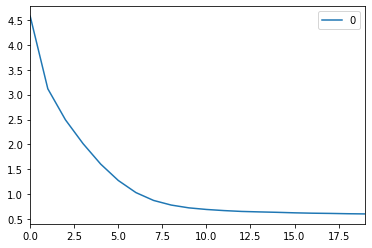

In [310]:
pd.DataFrame(history.history['loss']).plot()

## Save model

In [ ]:
# Save the weights
model.save_weights('test_model')

# Reset the model
embedding_dim = 256
rnn_units = 1024
test_model = TextGenModel(len(preprocessor.vocab), embedding_dim, rnn_units)

# Load the weights
test_model.load_weights('test_model')

## Generate new ad copywriting

In [274]:
# original
class TextGenerator:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def to_text(self, tokens):
        '''
        transfer tokens back to texts
        '''
        text = ''
        for t in tokens:
            word = self.tokenizer.index_word[t]
            text += word

        return text
    
    def generate_one_char(self, inputs, states=None, temperature=0.5):
        # sequence can be in any length, does not have to be the same as the training data
        sequence = self.tokenizer.texts_to_sequences([inputs])[0]
        
        # add batch dim
        inputs_seq = tf.expand_dims(sequence, axis=0)
        
        # call the model
        # difference btw call() & predict():
        # predict() handles larger inputs and can do multi batches
        # call() handles single batch
        pred_logits, states = self.model(inputs_seq, states=states, return_state=True)
        
        # each time a char passed in, rnn will gen a pred and pass the pred and state into the model for next pred
        # thus there will be serveral pred_logits according to how many inputs(chars) passed in
        
        # get the last pred cause that is the only result that we really want to predict
        # eg. 'ab' => 'abc', the 'c' is the only thing we care about
        last_char_pred_logits = pred_logits[:,-1,:]
        
        # devide the last_char_pred_logits by temperature(certain num)
        # the greater temperature means greater diversity
        last_char_pred_logits /= temperature
        pred_id = tf.random.categorical(last_char_pred_logits, num_samples=1)
        pred_id = tf.squeeze(pred_id, axis=1)
        pred_char = self.to_text(pred_id.numpy())
        
        return pred_char, states
    
    def generate_texts(self, start_text, text_length, temperature=0.5):
        states = None
        outputs_seq = [start_text]
        next_text = start_text
        
        for i in range(text_length):
            next_text, states = self.generate_one_char(next_text, states=states, temperature=temperature)
            outputs_seq.append(next_text)
            
        result = ''.join(outputs_seq)
        
        return result

## Result in action

In [302]:
text_gen = TextGenerator(model, tokenizer)
start_text = '馬上入手，'
text_length = 300
result = text_gen.generate_texts(start_text, text_length, temperature=0.8)
print(result)

馬上入手，
還在買1＋5雙只要2160
》中職聯名襪3雙只要830元，6雙更划算$1,600
再抽現金10萬 #按摩椅 #關島雙人來回機票
#footer除臭系列
#無效60天可退費
#再見了腳上的鹹魚味
#機能除臭襪全面特價中自從認識【footer】後，我的夏天就少了鹹魚的味道！
穿上footer除臭襪，除臭抑菌x瞬間，讓我全面特惠中自從認識【footer】後，我的夏天就少了鹹魚的味道！
穿出footer除臭襪，溫柔道謝🙇‍♀
#老爸襪愛哩
#照顧雙足再現爸氣一年３６５年，天天努力奮鬥清帳單（拭淚）
今天我來付👊
✔購買７雙＄１１８０
✔１雙最低只要１６８起
✔全館滿$800元即享免運
✔不限金額，消
